In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

## Initialize the Environment and Agent

The first step will be to load the environment built on unity, The we exctract "_brain_" information, which is the responsible of taking action in the environment.

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


From the information of the environment we get that the agent has at its disposal 4 action given by:

- `0` - walk forward;
- `1` - walk backward;
- `2` - turn left;
- `3` - turn right.

On the other hand the state is made of a 37-dimensional space containing the agent velocity of a ray-based perception for all the objects in the environment around the agent's forward direction.

The first step brefore to train our agent is to reset the environment, namely placing it in a random point in its available square space. The final goal for the agent will be to collect as much yellow banana as possibile (which will provide a reward of +1), while avoiding the blue banana (returning a penalty of -1).

The environment will be considered solved if the agent will collect at least an average overall reaward &ge;13 along 10 episode.

In [3]:
env_info = env.reset(train_mode=True)[brain_name]

It's now time to import the agent responsible to learn the task just described. 
In order to solve the task the idea is to implement a Deep Q-Network (DQN) that, at each time step or at every pre defined step interval, a neuarl networks (NN) aims to learn the best action, or more formally aims to approximate the state action-value providing a tool to find the more valuable action, to apply at that time istant provided the 37-dimensional state input.

At each optimization step the agent will take the action according to the model prediction and will exploit the obtained reward to optimize the NN weigths exploiting the gradiend descent technique.

In [4]:
from dqn_agent import Agent


action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

## Agent Training

We must be aware that DQN tends to overestimate action values. To avoid this issues, and to improve the learning phase, we apply some techniques that has been shown to be the more prominent ones.
Specifically we will resot to **_Double DQN_** (DDQN), **_Prioritized Experience Replay_** (PER) and, last but not least, **_Dueling DQN_** which combined with DDQN becomes **_Dueling DDQN_**.

1. ##### Double DQN
Double Q-Learning has shown great performances to avoid the issues of action values overestimation. To do so we start by analyzing the update rule for Q-Learning with NN function approximation, that is:
$$\omega_{i+1} = \omega_i + \alpha \left( R + \gamma \max_a Q(s', a'; \omega_i) - Q(s, a; \omega_i) \right) \nabla_{\omega_i} Q(s, a; \omega_i)$$
with TD target given by $R + \gamma \max_a Q(s', a'; \omega_i)$ or $R + \gamma Q(s', argmax_aQ(s', a, \omega), \omega)$. Here we can see that if $\omega$ are not well tuned, for instance at early stage, it might be easy to make mistakes.
To overcome this issues in the evaluation of the TD target we will resort to a different set of weights $\omega^-_i$ that will be updated parallely to the main weights according to the rule given by:
$$\omega^-_i = \tau * \omega_i + (1 - \tau) * \omega^-_i$$
where $\tau$ is a coefficent that aim to regularize the target update according to the local NN. Namely, if $\tau = 1$ means that the two networks coincide, and thus the Double DQN becomes a simple DQN, while if $\tau = 0$ the target NN is not getting updated. This parameter might be an hyperparameters interesting to tune or even changing along the training. However in this project it has been chosen fixed.

2. ##### Prioritized Experience Replay
In traditional deep reinforcement learning, Experience Replay enhances training by storing and randomly sampling past experiences. However, treating all experiences as equal can be inefficient. For this reason we will exploit Prioritized Experience Replay (PER).
PER revolutionizes the sampling process by assigning priorities to experiences based on their temporal difference (TD) errors. Larger TD errors signal unexpected or significant experiences, making them prime candidates for relearning. Instead of sampling uniformly, PER adjusts the probability of selecting a particular experience based on its TD error. Thus, experiences that offer more learning potential are revisited more often.
This non-uniform sampling, while efficient, introduces bias. To counteract this, importance-sampling weights are utilized, ensuring unbiased learning updates. In essence, PER combines the best of both worlds: the efficiency of prioritizing valuable experiences and the rigor of unbiased learning.

3. ##### Dueling DDQN
Dueling DQN introduces an architectural nuance to the DQN's neural network. Rather than directly estimating Q-values, it decouples the state values and the advantages of each action.
In a traditional setup, the neural network provides Q-values for actions given a state. With Dueling DQN, the architecture divides the final layer into two pathways: one for the state value function $ V(s; \omega) $ and another for the advantage function $ A(s, a; \omega) $ of each action. These are combined to produce Q-values:
$$Q(s, a; \omega) = V(s; \omega) + A(s, a; \omega)$$
By separating state value and action advantages, Dueling DQN allows for a more nuanced learning process, leading to potentially faster and more stable policies.

#### Other Hyperparameters

1. **DDQN Coefficent**: As previously state $\tau$ is the responsible on tuning the DDQN approach. For this experiment we set the values fixed to $\tau=5 \times 10^{-3}$.
2. **Learning Rate**: In the DQN's neural network, the learning rate (LR) determines the step size taken towards minimizing the loss during each update. Set initially to $1 \times 10^{-3}$, it dictates how aggressively our model adapts to new information. Furthermore, the learning rate decays at a rate of 0.9999 after each update, gradually reducing the step size and ensuring more refined learning as training progresses.
3. **Discount Factor**: The discount factor $ \gamma $, set at 0.95, influences how the DQN values future rewards in comparison to immediate ones. A value closer to 1 means the agent gives substantial importance to long-term rewards, ensuring that it's motivated to make decisions beneficial in the long run. This fit our case since the majority of the action are not supposed to return a positive reward or just only a reward different from 0.

4. **Exploration vs Exploitation**: In DQL, or in general for all RL framework, exploration vs exploitation is a critical balance to maintain. The parameter $\varepsilon$ dictates this balance. At the beginning of training, our agent knows little about its environment. Thus, it's beneficial to explore as much as possible, and this is facilitated by setting a high initial $\varepsilon$ value, $\varepsilon_{start} = 1.0$. This means the agent will predominantly take random actions, exploring the vastness of its state-action space.
However, as the agent interacts more with its environment and starts to learn, it's crucial to decrease the randomness and lean more towards exploiting what it has already learned. The $\varepsilon_{decay}$ factor, set at $0.999$, ensures a gradual decrease in the value of $\varepsilon$ after each episode, thus slowly transitioning the agent from an exploration-centric mode to an exploitation one.
Despite the importance of exploitation in the later stages of training, it's vital to retain some level of exploration throughout. This ensures that the agent doesn't become overly myopic and miss out on potential better strategies. The $\varepsilon_{end}$ parameter, set to $0.01$, is the floor for $\varepsilon$. It guarantees that the agent will always maintain a $1\%$ chance of taking a random action, preserving some exploratory behavior throughout its lifetime.



In [5]:
def dqn(n_episode = 1800, max_t= 1000, eps_start=1., eps_end=.01, eps_decay=.995):

    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon

    """

    scores = []                         # list containing scores from each episode
    scores_window = deque(maxlen=100)    # last 10 scores
    eps = eps_start                     # initialize epsilon
    best_scores = 11.0

    for i_episode in range(1, n_episode+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0] # reset the environment
        #print(state)
        score = 0

        for t in range(max_t):
            action = agent.act(state, eps) # select an action
            
            env_info = env.step(action)[brain_name] # send the action to the environment

            next_state = env_info.vector_observations[0] # get the next state
            reward = env_info.rewards[0]
            # change the reward to -0.01 if the agent doesn't get the banana
            if reward == 0:
                reward = -0.01
            done = env_info.local_done[0]

            agent.step(state, action, reward, next_state, done)

            score += reward # update the score
            state = next_state # roll over the state to next time step

            if done:
                break

        scores_window.append(score) # save most recent score
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)

        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, with epsilon:{:.5f}'.format(i_episode, np.mean(scores_window), eps))
        if np.mean(scores_window)>=best_scores:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'best_model.pth')
            best_scores = np.mean(scores_window)

            
    return scores

The learning algorithm itself run the agent iteratively through repeated episode. Each episode is give by a total of 300 steps allowed. At each steps:

1. The agent take the action according to the currently loaded model and a $\epsilon$-greedy policy. 
2. The action selected by the agest is sent to the environment and the information are stored for next evaluation. More specifically we are interested in the **_next_state_** reached, the **_reward_** returned, and the **_done_** flag that indicate if the episode is terminated or not.
3. The next step is a slight modification of the "reward framework", since we have modified the reward function to return a value of $-0.01$ rather than $0$ to incentivate the agent to loking for collecting banana. This has been done after some observation hoping to prevent the agent to get stucked sometimes in weird loop without taking any meaningful action.
4. Subsequently the agent will take its step by adding the current environment experience in its PER Buffer and once reached a minimun quantity of episode saved in its memory starting the learning phase. This procedure, and specifically the model update, is done every $4$ steps, according to the hyperparameter, and basically it consist in sampling a **_BATCH_SIZE_** number of episode randomly according to the probability defined by the TD error for each episode. Then using that sample set to update the NN model and "soft-updateing" the target model.
5. Finally store the score obtained combining the reward of the episode, and as last update the new $\epsilon$ reducing the randomness for action decision process.

Episode 10	Average Score: -2.89, with epsilon:0.95111
Episode 20	Average Score: -3.13, with epsilon:0.90461
Episode 30	Average Score: -3.29, with epsilon:0.86038
Episode 40	Average Score: -3.36, with epsilon:0.81832
Episode 50	Average Score: -3.16, with epsilon:0.77831
Episode 60	Average Score: -2.93, with epsilon:0.74026
Episode 70	Average Score: -2.81, with epsilon:0.70407
Episode 80	Average Score: -2.46, with epsilon:0.66965
Episode 90	Average Score: -2.13, with epsilon:0.63691
Episode 100	Average Score: -1.85, with epsilon:0.60577
Episode 110	Average Score: -1.55, with epsilon:0.57615
Episode 120	Average Score: -1.08, with epsilon:0.54799
Episode 130	Average Score: -0.50, with epsilon:0.52120
Episode 140	Average Score: -0.03, with epsilon:0.49571
Episode 150	Average Score: 0.42, with epsilon:0.47148
Episode 160	Average Score: 1.03, with epsilon:0.44843
Episode 170	Average Score: 1.55, with epsilon:0.42650
Episode 180	Average Score: 1.75, with epsilon:0.40565
Episode 190	Average Sco

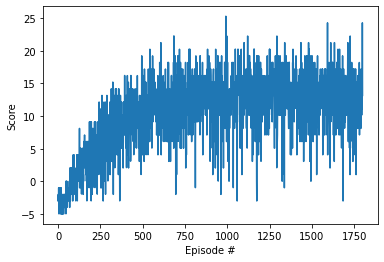

In [6]:
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In order to analyze the result obtained we begin reccaling the reward modification since with this we should expect an average score lower than the non modified version. To overcome this "issue", keeping in mind the total number of step is 300 and that the banana collection will be a sparse event, we lowered the threshold to consider the task solved from $13$ to $11$. However we didn't stop the training at the first model cabable to solve the task but we kept learning for all the steps allowed.

At the end of the training we can observe that the agend solved its task in exactly 560, however proceding with the training we are capable to reach the best result at episode 1324 reaching also the more strict threshold of 13 for the "non step penalizing" reward function.

In [9]:
# Test the agent

# initialize the score
score = 0
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('best_model.pth'))

for i in range(10):

    # initialize the environment
    state = env.reset(train_mode=False)[brain_name].vector_observations[0] # reset the environment

    # for each time step
    for j in range(1000):
        
        action = agent.act(state)
        env_info = env.step(action)[brain_name] # send the action to the environment
        state = env_info.vector_observations[0] # get the next state
        reward = env_info.rewards[0] # get the reward
        score += reward # update the score
        #if reward != 0:
        #    print('\rEpisode {}: Reward {}\tTotal Score: {:.2f}'.format(i+1,reward, score))
        done = env_info.local_done[0]

        if done:
            break 

print("Total average score: {}".format(score/10))
            

Total average score: 16.0


In [10]:
env.close()

In conclusion we tested the final traind agent on the environment observing that on an average of 10 episode it was able to collect an average of 16 banans for episode so we can considered the task completed soccesfuly!

<video width="640" height="480" controls autoplay loop>
  <source src="banana.mp4" type="video/mp4">
</video>